# 在交通监控数据TMonitor上训练Faster-RCNN

In [1]:
import os
import cv2
import sys
import time
import math
import json
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

# 项目根目录
ROOT_DIR = os.path.abspath("../../")
# 模型存放路径
MODEL_DIR = "./logs"
# 导入库
sys.path.append(ROOT_DIR)  #加入代码库到根目录
from frcnn.config import Config
from frcnn import utils
from frcnn import visualize
from frcnn.visualize import display_images
import frcnn.model as modellib
from frcnn.model import log

Using TensorFlow backend.


## 修改训练配置

In [2]:
class TMonitorConfig(Config):
    """修改配置文件
    继承并重载Config类
    """
    # 该配置的名字
    DATA_NAME = "TMonitor"
    TASK_NAME = "tricycle"

    # 在一个GPU上训练，每个GPU训练8张数据
    # Batch size 为 4 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4

    # 类别数量 (包括背景)
    NUM_CLASSES = 1 + 1  # 背景 + 1 三轮车

    # 确定输入尺寸
    IMAGE_MAX_DIM = 1280

    # 设置anchor的尺寸
    RPN_ANCHOR_SCALES = (64, 128, 256, 512, 1024)  # anchor的像素边长
    
    
    
config = TMonitorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
NAME                           TMonitor
NUM_CLASSES                    2
POOL_SIZE              

## 加载数据集信息

In [3]:
class TMonitorDataset(utils.Dataset):
    """数据集对象，数据标注格式如下：
    {
     "path": "/home/huyu/dl/project/ZJ-TWB-Detection-End2End/data/all/train/clip1-16.jpg",
     "outputs": {
                 "object": [
                            {
                             "name": "TWB", 
                             "bndbox": {"xmax": 573, "ymax": 495, "ymin": 319, "xmin": 378}
                            }, 
                            {
                             "name": "TWB", 
                             "bndbox": {"xmax": 942, "ymax": 437, "ymin": 254, "xmin": 795}
                            }
                           ]
                }, 
     "time_labeled": 1528094317109, 
     "size": {"width": 1280, "height": 720, "depth": 3}, 
     "labeled": true
     }
    """

    def load_TMonitor (self, dataset_dir, subset):
        """加载数据信息。
        dataset_dir: 数据集路径
        count: 要生成的图片数
        height, width: 图片的高宽
        """
        # 添加类
        self.add_class("TMonitor", 1, "tricycle")

        # 添加图片数据
        anno_dir = os.path.join(dataset_dir, subset, 'annotations')
        json_dirs = glob.glob(os.path.join(anno_dir, '*.json'))
        for json_dir in json_dirs:
            json_data = json.load(open(json_dir))
            path = json_data['path'] #图片路径
            image_id = path.split('/')[-1].split('.')[0] #用图片名作为id
            height, width = json_data['size']['height'], json_data['size']['width']
            objs = json_data['outputs']['object'] #检测目标
            self.add_image("TMonitor", image_id=image_id, path=path,
                            height=height, width=width, objs=objs)

In [4]:
# 训练数据的路径
dataset_dir = os.path.join(ROOT_DIR, 'data', 'all')
# 创建训练集
dataset_train = TMonitorDataset()
dataset_train.load_TMonitor(dataset_dir,'train')
dataset_train.prepare()
# 创建验证集
dataset_val = TMonitorDataset()
dataset_val.load_TMonitor(dataset_dir,'val')
dataset_val.prepare()

## 创建模型并加载权重

In [5]:
# coco预训练权重路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
# 创建训练模型
model = modellib.FasterRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
# 加载权重
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["frcnn_class_logits", "frcnn_bbox_fc", 
                           "frcnn_bbox"])
# 显示
visualize.display_weight_stats(model)

## 训练

In [ ]:
# 训练heads（除特征backbone外）部分
# 传入layers="heads"，冻结backbone
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=30, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/tmonitor20180627T0936/faster_rcnn_tmonitor_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
frcnn_class_conv1      (TimeDistributed)
frcnn_class_bn1        (TimeDistributed)
frcnn_class_conv2      (TimeDistributed)
frcnn_class_bn2        (TimeDistributed)
frcnn_bbox_fc          (TimeDistributed)
frcnn_class_logits     (TimeDistributed)


/home/huyu/software/anaconda3/envs/dl/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/huyu/software/anaconda3/envs/dl/lib/python3.5/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/30
   4/1000 [..............................] - ETA: 20670s - loss: 2.5830 - rpn_class_loss: 0.1738 - rpn_bbox_loss: 0.8768 - frcnn_class_loss: 0.8294 - frcnn_bbox_loss: 0.7031

## 检测

In [3]:
class InferenceConfig(TMonitorConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # 检测目标的置信度
    DETECTION_MIN_CONFIDENCE = 0.95

inference_config = InferenceConfig()

# 创建检测模型
model = modellib.FasterRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# 获取预训练模型
# 可以设置具体路径，或查找最新的模型路径
model_path = model.find_last()[1]
#model_path = os.path.join('./', 'logs', 'tmonitor20180622T1804', 'faster_rcnn_tmonitor_0015.h5')

# 加载训练好的权重
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)
# 显示
visualize.display_weight_stats(model)

Loading weights from  None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

[[204 115 332 238]
 [195 243 285 332]] [1 1] [0.99226016 0.9624123 ]
[[ 292  877  501 1013]
 [ 320  376  501  577]
 [ 229 1064  427 1245]
 [ 257  799  437  936]] [1 1 1 1] [0.99983346 0.9982888  0.99583083 0.9951023 ]
[[313 197 414 285]] [1] [0.9707464]
[[549  61 715 202]
 [404 500 581 655]
 [514 337 701 495]
 [500 221 678 358]] [1 1 1 1] [0.9995999  0.9994399  0.9970092  0.99357855]
[[412  79 656 307]
 [319 418 484 542]
 [299 526 433 647]] [1 1 1] [0.9999883 0.9999709 0.9999585]
[[ 417 1149  750 1406]
 [ 341 1387  567 1573]] [1 1] [0.9994522 0.9953518]
[[ 294 1002  514 1177]
 [ 255  794  438  940]
 [ 319  392  500  566]] [1 1 1] [0.9996282  0.99911326 0.9989536 ]
[[ 321  937  386 1011]
 [ 370 1079  495 1156]] [1 1] [0.9991398 0.9983015]
[[323 201 474 318]
 [304 317 427 405]
 [340  23 515 181]
 [296 437 426 553]] [1 1 1 1] [0.99998486 0.99988353 0.99833435 0.98299235]
[[ 355 1136  439 1230]
 [ 276  760  325  825]] [1 1] [0.99991405 0.95174813]
[[281 104 333 179]] [1] [0.96985483]
[[161

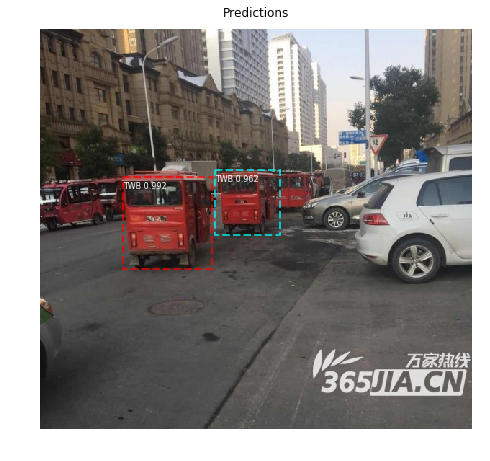

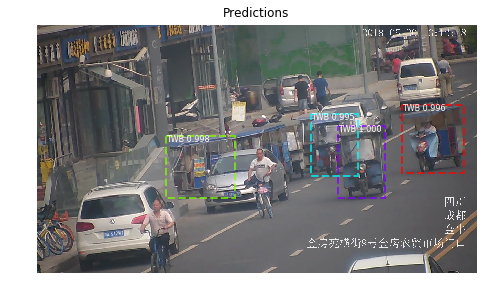

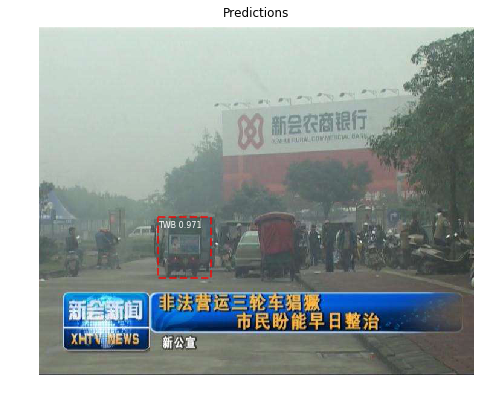

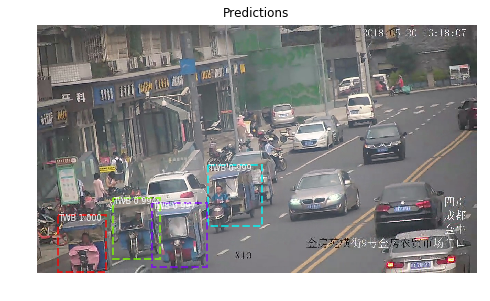

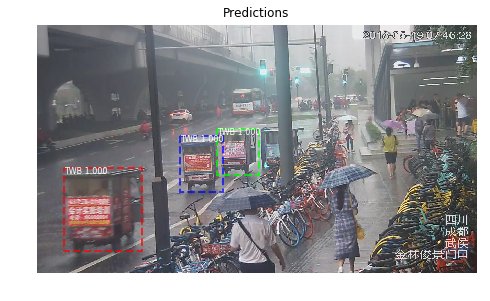

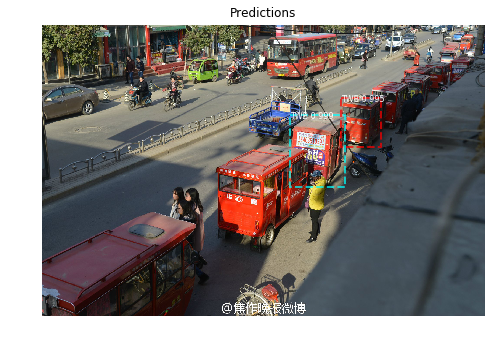

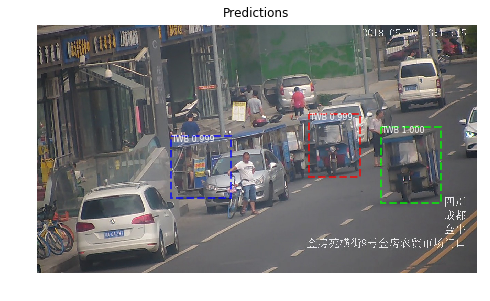

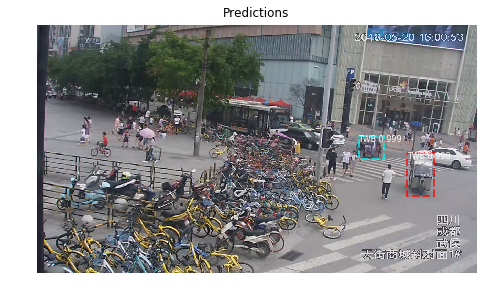

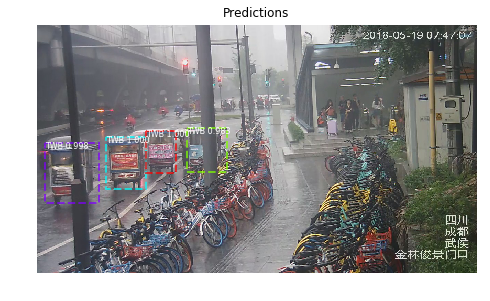

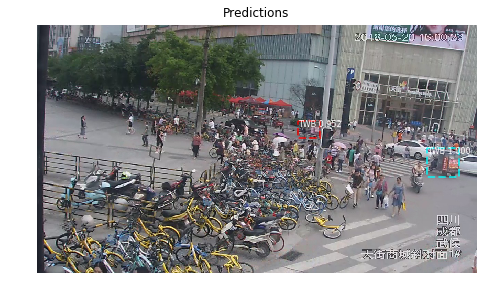

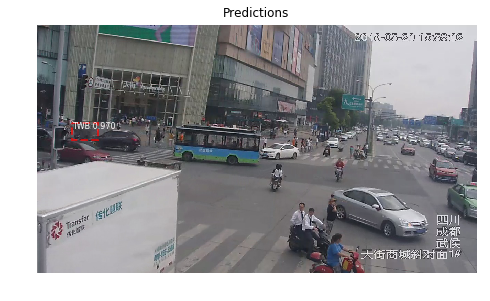

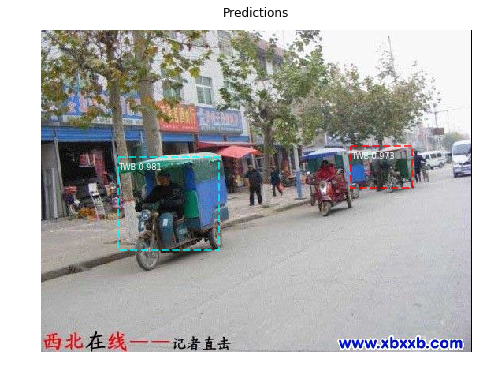

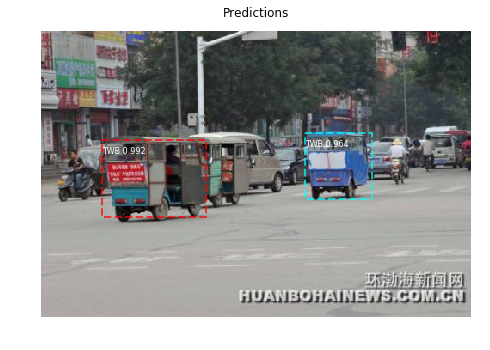

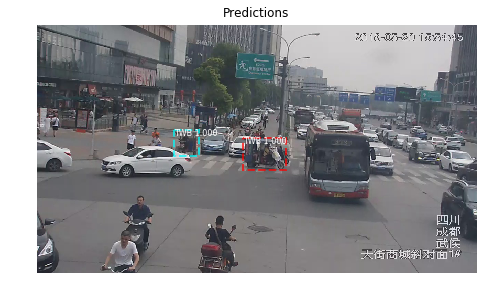

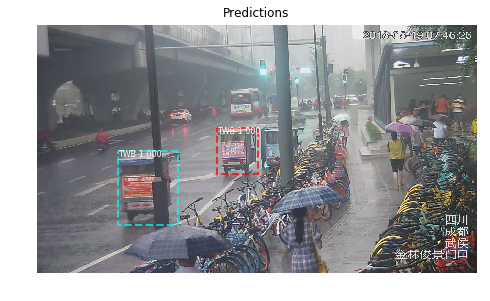

In [7]:
# 测试图片路径
test_file_dir = os.path.join(ROOT_DIR, 'test_images')
test_imgs_dir = glob.glob(os.path.join(test_file_dir, '*.jpg'))

all_time = []
for img_dir in test_imgs_dir:
    # 加载测试图片
    image = mpimg.imread(img_dir)
    # 运行检测
    start = time.clock() #检测开始的时间
    results = model.detect([image], verbose=0)
    end = time.clock() #检测结束的时间
    all_time.append(end-start) #运行检测的时间
    # 显示结果
    ax = get_ax(1)
    r = results[0]
    print(r['rois'], r['class_ids'],r['scores'])
    visualize.display_instances(image, r['rois'], r['class_ids'], 
                                dataset_train.class_names, r['scores'], ax=ax,
                                title="Predictions")
print('\n', 'Average Time of Detection:', np.mean(np.array(all_time)))